Importamos los módulos necesarios 

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from matplotlib.animation import FuncAnimation

Definimos las funciones necesarias para el programa

In [14]:
#Inicializa las posiciones iniciales aleatorios
@jit(nopython=True)
def init_spins (N):
    spins = np.random.choice(np.array([-1, 1]), (N,N))
    return spins

#Función que cambia el valor del spin
@jit(nopython=True)
def moves_spin (spins, N, T):
    #generate a random position
    pos = np.random.randint(0, N, size=(1, 2))[0]
    d_energy = 2*spins[pos[0], pos[1]]*(spins[(pos[0]+1)%N, pos[1]] + spins[(pos[0]-1)%N, pos[1]] + spins[(pos[0]), (pos[1]-1)%N] + spins[(pos[0]), (pos[1]+1)%N] )
    p = min(1, np.exp(-d_energy/T))
    xi = np.random.rand()
    if(xi < p):
        spins[pos[0], pos[1]] = -spins[pos[0], pos[1]]
    return spins

#Función que genera los puntos para ser usado en la animación de ising
@jit(nopython=True)
def ising (N, T, n_data, dt):
    step = dt * N**2

    spins = init_spins(N)
    all_spins = np.zeros((n_data, N, N))

    i =0
    while (i < n_data):
        j = 0
        mag = 0
        while (j < step):
            spins = moves_spin(spins, N, T)
            mag += magnetization(spins, N)
            j+=1
        all_spins[i] = spins
        i+=1
    return all_spins, mag


#Función que devuelve la energía del sistema
@jit(nopython=True)
def energy(spins, N):
    sum = 0
    for i in range(N):
        for j in range(N):
            sum += spins[i, j]*(spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[(i), (j-1)%N] + spins[(i), (j+1)%N])
    return -sum/2

#Función que devuelve la probabilidad 
@jit(nopython=True)
def probability (energy, T, k):
    return np.exp((-energy)/(k*T))

#Función que devuelve la magnetización del sistema
@jit(nopython=True)
def magnetization (spins, N):
    sum = 0
    for i in range(N):
        for j in range(N):
            sum += spins[i, j]
    return sum/(N**2)

#Función que devuelve el promedio de la magnetización
@jit(nopython=True)
def total_magnetization (T, N, time, dt, k):
    step = dt * N**2
    n_data = int(time/dt)

    spins = init_spins(N)
    all_spins = np.zeros((n_data, N, N))
    prob = np.zeros(n_data)
    m = np.zeros(n_data)

    z = 0
    M = 0

    i =0
    while (i < n_data):
        j = 0
        mag = 0
        while (j < step):
            spins = moves_spin(spins, N, T)
            mag += magnetization(spins, N)
            j+=1
        all_spins[i] = spins
        ener = energy(spins, N)
        m[i] = mag/step
        prob[i]=probability(ener, T, k)
        M += m[i]*prob[i]
        z += prob[i]
        i+=1

    return M/z

In [15]:
N = 8
T = np.arange(0.5, 5, 0.5)
k = 1
time_ising = 10**3
dt_ising = 1
n_data = int(time_ising/dt_ising)
ising_data = np.zeros((len(T), n_data, N, N))

In [16]:
i = 0
while (i < len(T)):
    ising_data[i], = ising(N, T[i], n_data, dt_ising)
    i +=1

In [17]:
time = 10**6
dt = 100

mag = np.zeros(len(T))

i = 0
while(i < len(T)):
    mag[i] = total_magnetization(T[i], N, time, dt, k)
    i+=1

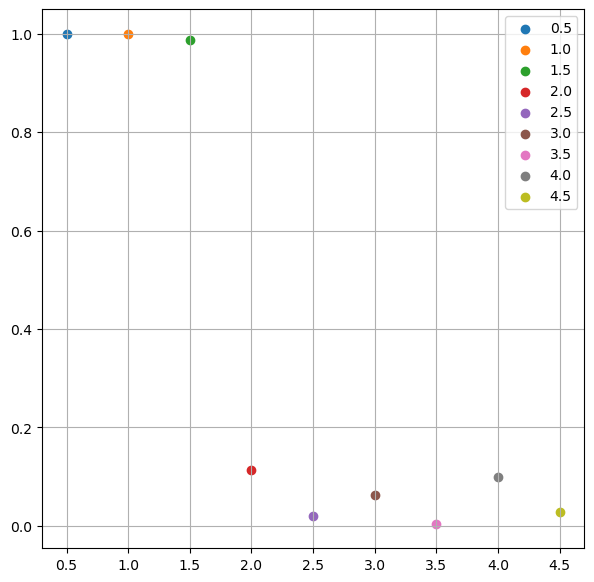

In [18]:
fig=plt.figure(figsize=(7,7)) #Size of the plot
ax=fig.add_subplot(111)
for i in range(len(T)):
    plt.scatter(T[i], abs(mag[i]), label = f'{T[i]}')
plt.legend()
plt.grid()

fig.savefig("{}.png".format(f'magnetizacion_{N}'))

In [19]:
def update(j_frame, frames_data, im):
    # Actualiza el gráfico con la configuración del sistema
    im.set_data(frames_data[j_frame])

    return im,

fig=plt.figure(figsize=(7,7)) #Size of the plot
ax=fig.add_subplot(111)

i = 0
while (i < len(T)):
    im = ax.imshow(ising_data[i][0], cmap="binary", vmin=-1, vmax=+1)
    animation = FuncAnimation(
            fig, update,
            fargs=(ising_data[i], im), frames=len(ising_data[i]), blit=True, interval=10)
    animation.save("{}.mp4".format(f"video/N_{N}T_{(i+1)*0.5}"), dpi=100)
    i+=1

plt.close()